# Bitcoin Forecasting using LSTM Model

Why do we use a LSTM Model ? 
- 1 Nonlinear Modeling: LSTM can handle complex, nonlinear patterns in time series data.
- 2 Sequential Memory: LSTM's ability to learn long-term dependencies in data makes it more suited for tasks where past trends impact future values.
- 3 Lower RMSE: Significantly better performance in forecasting compared to statistical models.

## 0 - Importing libraries 

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import tensorflow as tf
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_percentage_error

## 1 - ETL : Extraction Transformation Loading  

### 1.1 Extraction from yfinance lib 

In [77]:
import yfinance as yf

# Download historical data for Bitcoin (BTC-USD)
end = datetime.now()
btc_data = yf.download('BTC-USD', 
                       start='2012-01-01', 
                       end=end, 
                       interval='1d')  # daily data

print(btc_data.head())

[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker         BTC-USD     BTC-USD     BTC-USD     BTC-USD   BTC-USD
Date                                                                
2014-09-17  457.334015  468.174011  452.421997  465.864014  21056800
2014-09-18  424.440002  456.859985  413.104004  456.859985  34483200
2014-09-19  394.795990  427.834991  384.532013  424.102997  37919700
2014-09-20  408.903992  423.295990  389.882996  394.673004  36863600
2014-09-21  398.821014  412.425995  393.181000  408.084991  26580100


### 1.2 Transormation 

In [79]:
# Flatten the multi-index columns
btc_data.columns = btc_data.columns.get_level_values(1)
btc_data.head()

Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100


In [81]:
# Rename columns 
btc_data.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
btc_data.head()

,Close,High,Low,Open,Volume
Date,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100


In [11]:
# Reset index to move 'Date' back to a column 
btc_data.reset_index(inplace=True)
btc_data.head()

,Date,Close,High,Low,Open,Volume
0,2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
1,2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2,2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
3,2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
4,2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100


In [83]:
# adding features for the EDA  
# Moving averages capture ungoing trends, widely used in finance 

# Short-term moving average 30 days 
btc_data['MA_30d'] = btc_data['Close'].rolling(window=30).mean()  

# Medium-term moving average 4 months 
btc_data['MA_4m'] = btc_data['Close'].rolling(window=120).mean() 

# Long-term moving average 1 year 
btc_data['MA_1y'] = btc_data['Close'].rolling(window=365).mean()  

btc_data.head()

,Close,High,Low,Open,Volume,MA_30d,MA_4m,MA_1y
Date,,,,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800,NaN,NaN,NaN
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200,NaN,NaN,NaN
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700,NaN,NaN,NaN
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600,NaN,NaN,NaN
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100,NaN,NaN,NaN


In [67]:
import warnings
warnings.filterwarnings("ignore")

In [85]:
# filling the NaN values of the MA's with bfill method 

btc_data['MA_30d'].fillna(method='bfill', inplace = True )
btc_data['MA_4m'].fillna(method='bfill', inplace = True )
btc_data['MA_1y'].fillna(method='bfill', inplace = True )

btc_data.head()

,Close,High,Low,Open,Volume,MA_30d,MA_4m,MA_1y
Date,,,,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800,384.112801,353.058316,281.916161
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200,384.112801,353.058316,281.916161
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700,384.112801,353.058316,281.916161
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600,384.112801,353.058316,281.916161
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100,384.112801,353.058316,281.916161


### 1.3 Loading 

In [176]:
# saving the dataframe in a CSV file 

btc_data.to_csv('btc_data.csv', index=False)

## 2 - EDA : Exploratory Data Analysis 

### 2.1 Data Inspection 

In [178]:
btc_data.shape

(3774, 8)

our dataset contains 8 columns over 3774 rows 

In [181]:
print("Summary Statistics:\n", btc_data.describe())

Summary Statistics:
                Close           High            Low           Open  \
count    3774.000000    3774.000000    3774.000000    3774.000000   
mean    19891.434619   20312.288561   19403.203033   19867.485723   
std     22606.782475   23065.185450   22071.897307   22577.310464   
min       178.102997     211.731003     171.509995     176.897003   
25%      1242.402496    1259.017487    1215.972504    1234.160034   
50%      9389.831543    9554.184082    9233.823730    9383.452637   
75%     31267.944824   31999.373047   30243.574707   31155.519043   
max    106140.601562  108268.445312  105291.734375  106147.296875   

             Volume        MA_30d         MA_4m         MA_1y  
count  3.774000e+03   3774.000000   3774.000000   3774.000000  
mean   1.868725e+10  19523.696189  18461.510035  16306.465427  
std    2.040290e+10  22033.049240  20306.821395  17458.592713  
min    5.914570e+06    225.519800    242.674442    265.224978  
25%    4.359298e+08   1163.187392   1

In [91]:
btc_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3774 entries, 2014-09-17 to 2025-01-16
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3774 non-null   float64
 1   High    3774 non-null   float64
 2   Low     3774 non-null   float64
 3   Open    3774 non-null   float64
 4   Volume  3774 non-null   int64  
 5   MA_30d  3774 non-null   float64
 6   MA_4m   3774 non-null   float64
 7   MA_1y   3774 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 265.4 KB


In [93]:
# checking for duplicated rows 
if int(btc_data.duplicated().sum()) == 0 : 
    print("No duplicated rows") 
else: 
    print("Duplicated rows")

No duplicated rows


In [95]:
# checking for null values 
if btc_data.isnull().any().any():  
    print("Null values found") 
else:  
    print("No null values")


No null values


### 2.2 Vizualisation 

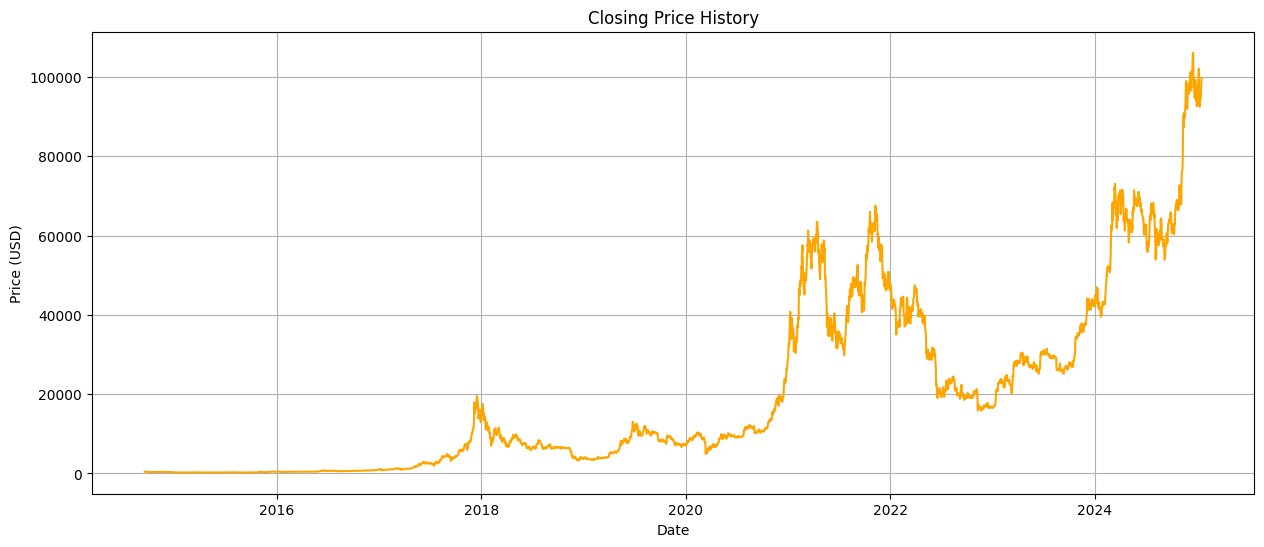

In [184]:
# plotting historical Bitcoin Price 

plt.figure(figsize=(15, 6)) 
plt.plot(btc_data.index, btc_data['Close'], label='Bitcoin price', color='orange')
plt.title("Closing Price History")
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid()
plt.show()

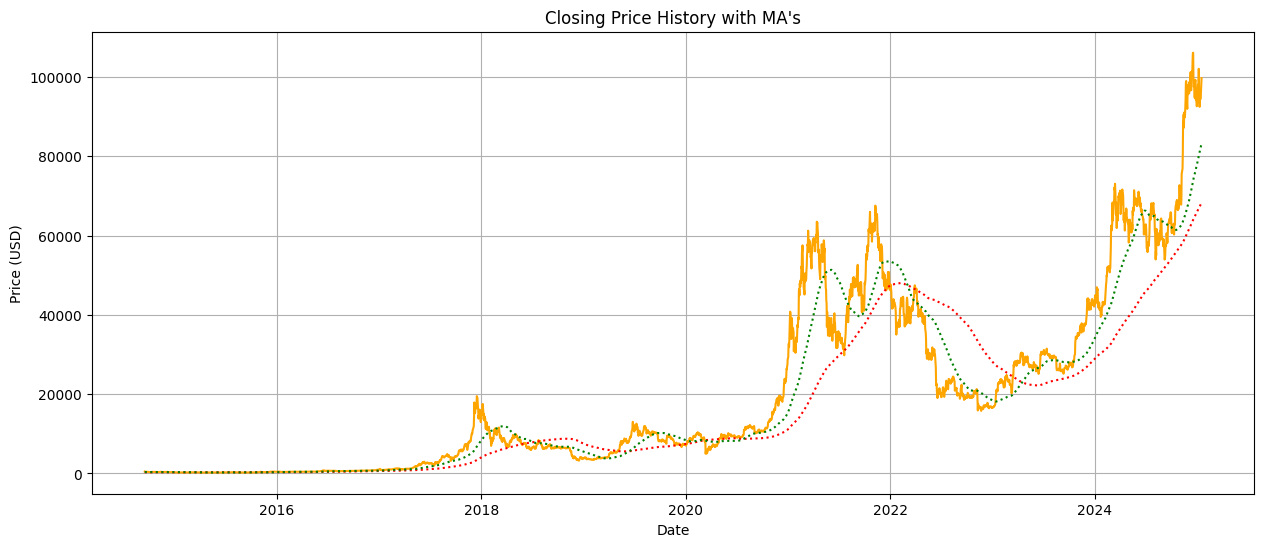

In [188]:
# plotting historical Bitcoin Price with MA's 
plt.figure(figsize=(15, 6)) 
plt.plot(btc_data.index, btc_data['Close'], label='Bitcoin price', color='orange')
plt.plot(btc_data.index, btc_data['MA_1y'], label='Bitcoin MA 1y', color='red', linestyle='dotted')
plt.plot(btc_data.index, btc_data['MA_4m'], label='Bitcoin MA 4m', color='green', linestyle='dotted')
plt.title("Closing Price History with MA's")
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid()
plt.show()

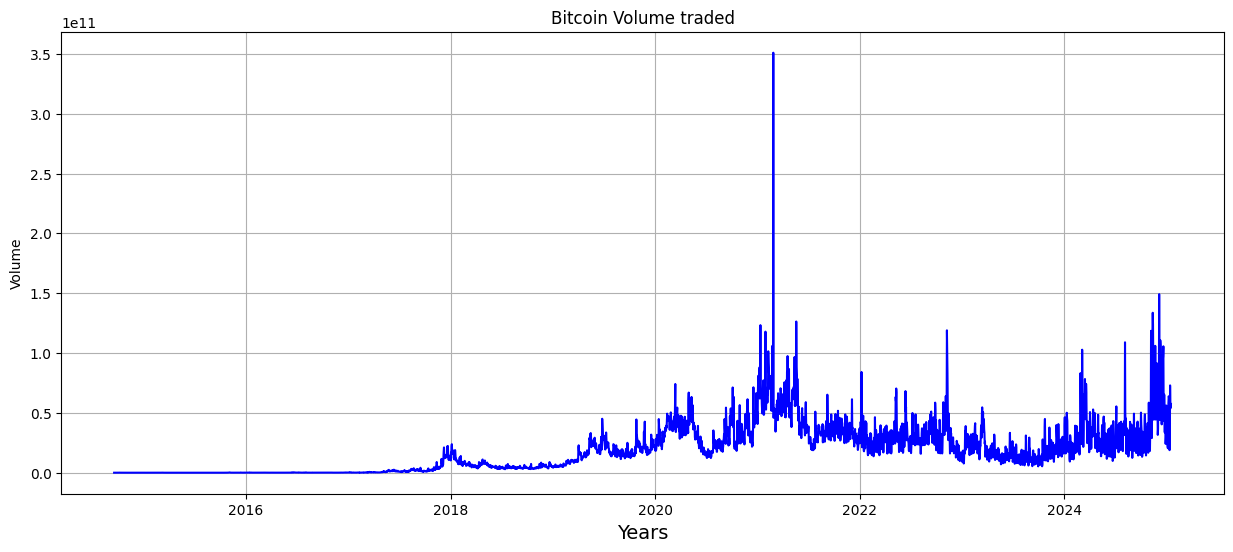

In [105]:
# plotting Bitcoin volume traded 

plt.figure(figsize=(15, 6)) 
plt.plot(btc_data.index, btc_data['Volume'], label='Volume traded', color='blue')
plt.title("Bitcoin Volume traded")
plt.xlabel("Years", fontsize = 14)
plt.ylabel('Volume')
plt.grid()
plt.show()

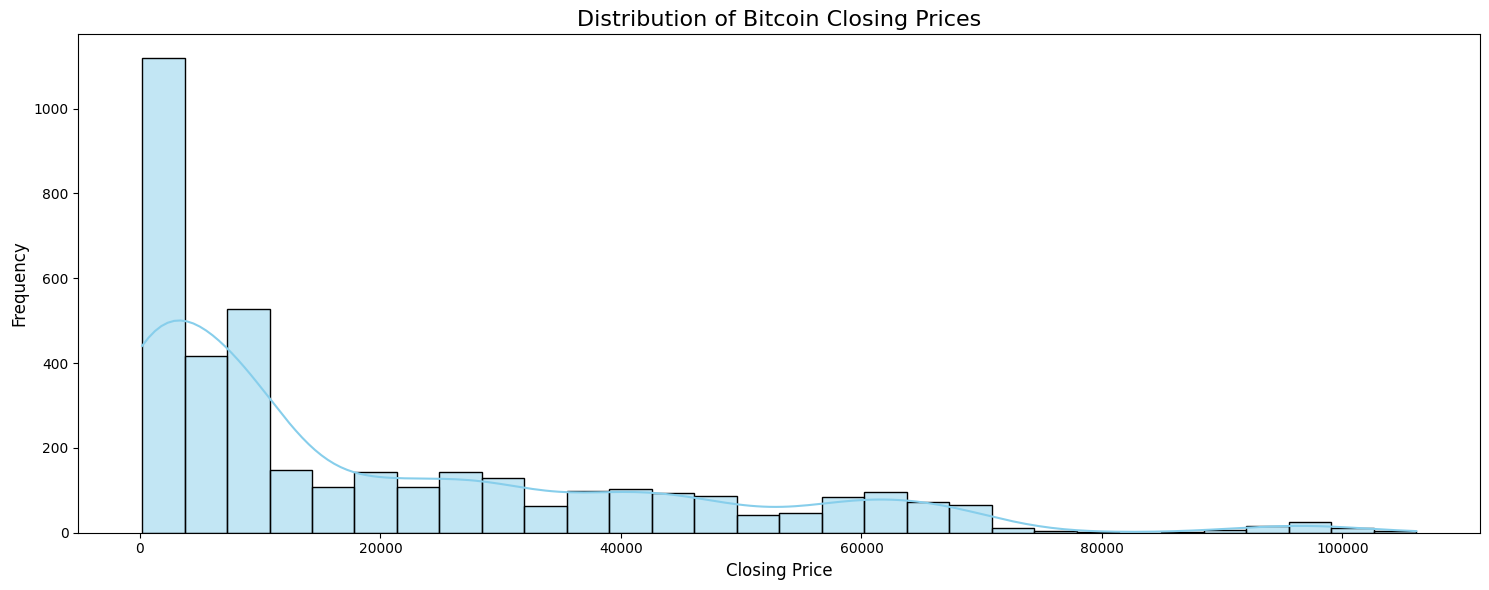

In [107]:
# Plotting the Bitcoin closing price distribution / histogram

plt.figure(figsize=(15, 6))
sns.histplot(btc_data['Close'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Bitcoin Closing Prices', fontsize=16)
plt.xlabel('Closing Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

## 3 - Data Preprocessing 

### 3.1 Choosing prediction column 

In [109]:
df = btc_data['Close']
#Close price data
df = btc_data[['Close']]
df.shape

(3774, 1)

In [111]:
df['Close']

Date
2014-09-17      457.334015
2014-09-18      424.440002
2014-09-19      394.795990
2014-09-20      408.903992
2014-09-21      398.821014
                  ...     
2025-01-11    94566.593750
2025-01-12    94488.437500
2025-01-13    94516.523438
2025-01-14    96534.046875
2025-01-16    99732.585938
Name: Close, Length: 3774, dtype: float64

According to our previous plot, the Closing data isn't normally distributed. We'll run a quick test and choose a scaling method accordingly : 

In [113]:
from scipy.stats import shapiro
stat, p = shapiro(df)
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Data is normally distributed')
else:
    print('Data is not normally distributed \nThus well go for a MinMaxScaling method ')

Statistics=0.819, p=0.000
Data is not normally distributed 
Thus well go for a MinMaxScaling method 


### 3.2 Scaling 

In [115]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']])

In [117]:
len(scaled_data)

3774

### 3.3 Prepare Training & Testing Set 

In [119]:
# Prepare data for lstm
x_data = []
y_data = []

window =100 # create sliding window 

for i in range(window, len(scaled_data)):
    x_data.append(scaled_data[i-window: i])
    y_data.append(scaled_data[i])
x_data = np.array(x_data)
y_data = np.array(y_data)

In [121]:
# Split into train and test sets
train_size = int(len(x_data) * 0.9)
x_train , y_train = x_data[:train_size], y_data[:train_size]
x_test, y_test = x_data[train_size:], y_data[train_size:]

## 4 - Model Training 

In [59]:
import warnings
warnings.filterwarnings("ignore")


In [123]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential([
    LSTM(128, return_sequences = True, input_shape = (x_train.shape[1], 1)),
    LSTM(64, return_sequences = False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer = "adam", loss = "mean_squared_error")
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 100, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,619 (459.45 KB)

 Trainable params: 117,619 (459.45 KB)

 Non-trainable params: 0 (0.00 B)

In [125]:
model.fit(x_train, y_train, batch_size = 5, epochs = 10)

Epoch 1/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - loss: 0.0024
Epoch 2/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - loss: 3.0981e-04
Epoch 3/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - loss: 2.2448e-04
Epoch 4/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - loss: 1.8120e-04
Epoch 5/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - loss: 1.2084e-04
Epoch 6/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - loss: 1.5005e-04
Epoch 7/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - loss: 1.0289e-04
Epoch 8/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - loss: 1.2405e-04
Epoch 9/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - loss: 1.1858e-04
Epoch 10/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - loss: 1.0217e-04


In [127]:
model.save("model5.keras")

## 5 - Predictions 

In [139]:
predictions = model.predict(x_test)
inv_predictions = scaler.inverse_transform(predictions)
inv_y_test = scaler.inverse_transform(y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [141]:
plotting_data = pd.DataFrame(
    {
        'Original': inv_y_test.flatten(), 
        'Prediction': inv_predictions.flatten(),
    }, index = df.index[train_size + window:]
)

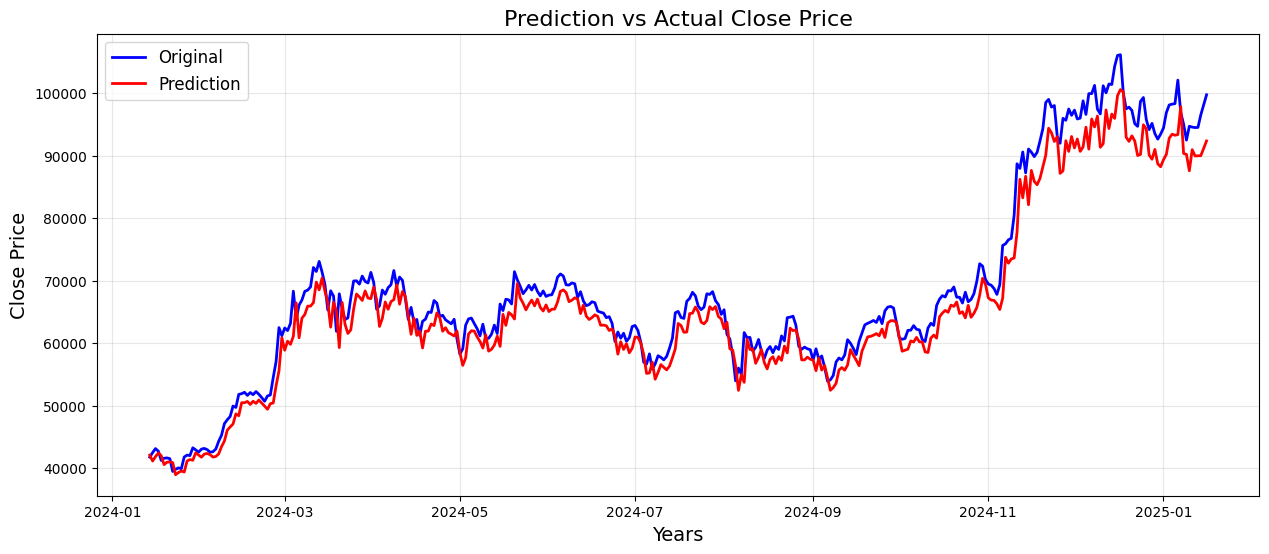

In [143]:
# Plotting predictions vs actual values 

plt.figure(figsize = (15, 6))
plt.plot(plotting_data.index, plotting_data['Original'], label = 'Original', color = 'blue', linewidth =2)
plt.plot(plotting_data.index, plotting_data['Prediction'], label = 'Prediction', color = 'red',  linewidth =2)

plt.title("Prediction vs Actual Close Price", fontsize = 16)
plt.xlabel("Years", fontsize = 14)
plt.ylabel('Close Price', fontsize = 14)
plt.grid(alpha = 0.3)
plt.legend(fontsize = 12)
plt.show()

In [145]:
# Predict future days
last_100  = scaled_data[-100:].reshape(1, -1, 1)
future_predictions=[]
for _ in range(10):
    next_days = model.predict(last_100)
    future_predictions.append(scaler.inverse_transform(next_days))
    last_100 = np.append(last_100[:, 1:, :], next_days.reshape(1, 1, -1), axis = 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


## 6 - Model Evaluation 

In [151]:
MAPE = mean_absolute_percentage_error(inv_y_test, inv_predictions)
Accuracy = 1 - MAPE
print("Test MAPE:", round(MAPE,3))
print("Test Accuracy:", round(Accuracy,2))

Test MAPE: 0.038
Test Accuracy: 0.96


## Let's conclude on this Non Financial Advice : Buy BITCOIN ! 